# Adversarial Attack 

- develop a model for mnist dataset using fastai
- attack the model using foolbox (black box attack)
- check the density & coverage metrics

In [1]:
# dependencies
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import numpy as np
from n2gem.metrics import gem_build_coverage, gem_build_density
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import torchvision
from fastai.vision.all import *

Fix the seed generator

In [3]:
torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device); print(torch.cuda.memory_allocated())
torch.cuda.device_count()

cpu
0


0

### Import the MNIST dataset 

In [5]:
def load_mnist():
    """Function to load the mnist
        The foolowing transform is aaplied: Normalize:(0.1307,)(0.3081,)
    
    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081))
    ])
    train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
    test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)
    
    return train_set, test_set

train_set, test_set = load_mnist()

-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------

## Check the metrics for various split of the entire dataset

- This section is created to check density and coverage for the entire dataset
- The dataset is split based on various ```split_size``` using ```stratify```
- For each split, the density and coverage is computed.

#### Example: 
- for ```split_size``` of 0.4, the ```X_model```

In [18]:
from torch.utils.data import ConcatDataset
# combine the datasets
dataset = ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)
myranges = np.linspace(0.05, 0.4, 10) 
density_check = []
coverage_check = []
val_length = []
for i in myranges:
        X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=i, random_state=42, stratify=np.array(Y))
        real = np.array(X_model).reshape(len(X_model), -1)
        gen = np.array(X_validation).reshape(len(X_validation), -1)
        den = gem_build_density(real, real.shape[0], gen, 'indexflatl2')
        cov = gem_build_coverage(real, real.shape[0], gen, 'indexflatl2')
        density_check.append(den); coverage_check.append(cov); val_length.append(len(X_validation))
        #print(f"Split size: {i:.2f} | Validation size: {len(X_validation)} | Density: {den:.5f} | Coverage: {cov:.5f}")

#### Visualization

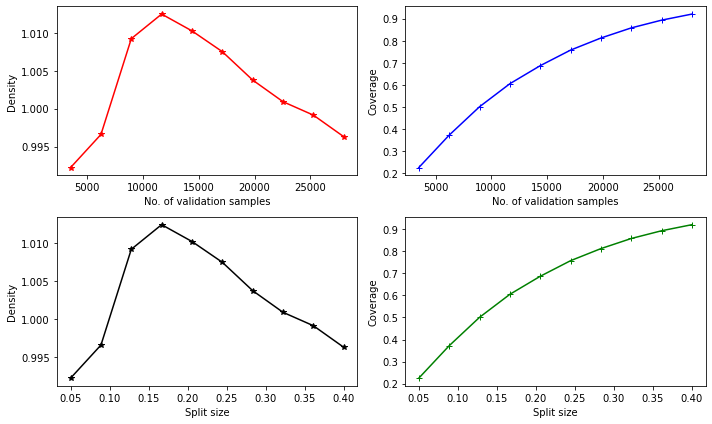

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax[0,0].plot(val_length, density_check, 'r-*')
ax[0,0].set_xlabel("No. of validation samples")
ax[0,0].set_ylabel("Density")


ax[0,1].plot(val_length, coverage_check, 'b-+')
ax[0,1].set_xlabel("No. of validation samples")
ax[0,1].set_ylabel("Coverage")

ax[1,0].plot(myranges, density_check, 'k-*')
ax[1,0].set_xlabel("Split size")
ax[1,0].set_ylabel("Density")


ax[1,1].plot(myranges, coverage_check, 'g-+')
ax[1,1].set_xlabel("Split size")
ax[1,1].set_ylabel("Coverage")
fig.tight_layout()
plt.savefig("Metrics_for_different_splitsizes.png")

#### Check on coverage using only 2 class

In [6]:
from torch.utils.data import ConcatDataset
# combine the datasets
dataset = ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)

In [21]:
X = torch.from_numpy(np.array(X)).cpu(); Y=torch.from_numpy(np.array(Y)).cpu();
#print(np.unique(Y, return_counts=True)); 
class0 = np.where(Y==0)[0]; class1 = np.where(Y==1)[0]; #print(len(class0), len(class1)); 
newX = X.reshape(X.shape[0], -1); #print(newX.shape)

classCom = torch.from_numpy(np.vstack([newX[class0], newX[class1]])).cpu()

#newX[class0].shape
coverage00 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class0], 'indexflatl2')
coverage005 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class0][:3452,...], 'indexflatl2')
coverage01 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class1], 'indexflatl2')
coveragecom = gem_build_coverage(classCom, classCom.shape[0], newX[class0], 'indexflatl2')
coveragecom5 = gem_build_coverage(classCom, classCom.shape[0], newX[class0][:600,...], 'indexflatl2')
print(f"Coverage: \n Class 0 & Class 0: {coverage00} \n Class 0 & Class 0 (50%): {coverage005} \n" +
      f" Class 0 & Class 1: {coverage01} \n \n Class 0 + Class 1 combined: {coveragecom} \n" +
     f" Class 0 + Class 1 combined(10%): {coveragecom5}")

Coverage: 
 Class 0 & Class 0: 1.0 
 Class 0 & Class 0 (50%): 0.9701579213142395 
 Class 0 & Class 1: 0.0020281036850064993 
 
 Class 0 + Class 1 combined: 0.4673207104206085 
 Class 0 + Class 1 combined(10%): 0.19668470323085785


------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------

### Combine the datasets and stratify split 
- Combine train and test
- form the model_dataset[training+ test] and validation set
- obtain training & test set to train on the model from model_dataset

In [7]:
from torch.utils.data import ConcatDataset
from sklearn.model_selection import train_test_split

def create_dataset(train_set, test_set, vali_split, test_split):
    """Function to split the dataset and form the training, test and validation datasets
        
        Parameters
        ----------------------
        train_set: torch.utils.mnist.dataset
        test_set: torch.utils.mnist.dataset
        vali_split: the size for the validation set 
        test_split: the size of the test set
        
        Return
        ----------------------
        X_trainset: list, size: train_size, 1, 28, 28
        X_testset: list, size: test_size, 1, 28, 28
        X_validation: list, size: vali_size, 1, 28, 28
        y_trainset: list, size: train_size
        y_testset: list, size: test_size
        y_valiset: list, size: vali_size
        
    """
    # combine the datasets
    dataset = ConcatDataset([train_set, test_set])
    X=[]; Y=[];
    for i in range(len(dataset)):
        x, y = dataset[i]
        X.append(x.numpy())  #.detach().cpu().numpy())
        Y.append(y)
    
    # split the dataset into train and validation set
    X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=vali_split, random_state=42, stratify=np.array(Y))

    print("X_validation_set size: ", np.array(X_validation).shape)
    print("Y_validation_set size: ", len(y_validation))

    
    # split the X_model, y_model into training set & test set
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_model, y_model, test_size=test_split, random_state=42, stratify=np.array(y_model))
    print("X_train_set size: ", np.array(X_trainset).shape)
    print("Y_train_set size: ", len(y_trainset))
    print("X_test_set size: ", np.array(X_testset).shape)
    print("Y_test_set size: ", len(y_testset))
    
    #X = np.array(X); Y = np.array(Y)
    
    return X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation

X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(train_set, test_set, 0.03, 0.2)

X_validation_set size:  (2100, 1, 28, 28)
Y_validation_set size:  2100
X_train_set size:  (54320, 1, 28, 28)
Y_train_set size:  54320
X_test_set size:  (13580, 1, 28, 28)
Y_test_set size:  13580


### Convert the datasets to Torch.TensorDataset

In [8]:
def convert_tensor(X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation):
    """
    Function to convert the split datasets into torch Tensor dataset
    
    Parameters
    ----------------------
    X_trainset: list, size: train_size, 1, 28, 28
    X_testset: list, size: test_size, 1, 28, 28
    X_validation: list, size: vali_size, 1, 28, 28
    y_trainset: list, size: train_size
    y_testset: list, size: test_size
    y_valiset: list, size: vali_size
    
    Return
    -------------------
    train_set: TensorDataset, consists of training images and labels
    test_set: TensorDataset, consists of test images and labels
    validation_set: TensorDataset, consists of validation images and labels
    
    # for the adversarial attack
    model_dataset_images: Tensor, size: (training + test) size, only the images
    model_dataset_images: Tensor, size: (training + test) size, only the labels
    """
    X_trainset = torch.Tensor(X_trainset); 
    y_trainset = torch.Tensor(y_trainset).type(torch.LongTensor) #dtype = torch.long);
    X_testset = torch.Tensor(X_testset); 
    y_testset = torch.Tensor(y_testset).type(torch.LongTensor);
    X_validation = torch.Tensor(X_validation); 
    y_validation = torch.Tensor(y_validation).type(torch.LongTensor)
    # y - label should be longTensor for fastai training
    
    # form model_dataset
    model_dataset_images = torch.vstack((X_trainset, X_testset))
    model_dataset_labels = torch.cat((y_trainset, y_testset))
    
    # form the Tensor dataset
    train_set = torch.utils.data.TensorDataset(X_trainset, y_trainset)
    test_set = torch.utils.data.TensorDataset(X_testset, y_testset)
    validation_set = torch.utils.data.TensorDataset(X_validation, y_validation)
    
    return train_set, test_set, validation_set, model_dataset_images, model_dataset_labels

train_set, test_set, validation_set, model_images, model_labels = convert_tensor(X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation)

In [21]:
torch.save(model_images, 'model_dataset_images.pt')
torch.save(model_labels, 'model_dataset_labels.pt')

In [22]:
torch.save(X_validation, 'validation_images.pt')
torch.save(y_validation, 'validation_labels.pt')

### The Dataloader for the CNN models

In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

### Define the CNN model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [5]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

### Fastai classifier
- Fastai takes the available device by default

In [11]:
data = DataLoaders(train_loader, test_loader)
learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)

- Initial fit for the model

In [12]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.168212,0.113628,0.964065,00:05
1,0.095370,0.060073,0.981002,00:03
2,0.072611,0.048427,0.985125,00:03


- Unfreeze and check the optimal learning rate

SuggestedLRs(valley=tensor(3.3113e-06))

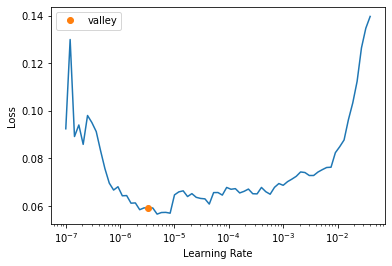

In [13]:
learn.unfreeze()
learn.lr_find()

- Fit the model again

In [14]:
learn.fit_one_cycle(8, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.071336,0.048203,0.985125,00:03
1,0.061386,0.047559,0.984904,00:03
2,0.062562,0.046872,0.984904,00:03
3,0.071075,0.046369,0.985125,00:03
4,0.061507,0.046122,0.985346,00:03
5,0.065839,0.046019,0.985420,00:03
6,0.063768,0.046045,0.985641,00:03
7,0.062972,0.046035,0.985641,00:03


In [16]:
#learn.recorder.plot_loss()

- Fine tune the model 

In [17]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.120263,0.065498,0.979750,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.064480,0.040627,0.987629,00:03
1,0.069494,0.044321,0.986230,00:03
2,0.051842,0.032422,0.989691,00:03
3,0.047426,0.030197,0.991090,00:03
4,0.035231,0.029030,0.991164,00:03


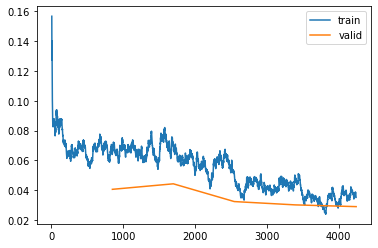

In [18]:
learn.recorder.plot_loss()

### - Save the fastai classifier
- By default it is saved in the /models folder with .pth extension

In [23]:
learn.save('./fastai_cnn_NewNet_99_splitDataset')

Path('models/fastai_cnn_NewNet_99_splitDataset.pth')

- Load the model(fastai) and save it as torch model for foolbox compatibility

In [24]:
model_new = learn.load('fastai_cnn_NewNet_99_splitDataset')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_99_splitDataset_weights.pth')

---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------

### Load model for the attack

In [6]:
# load the NewNet model
MyModel = NewNet()
MyModel.load_state_dict(torch.load('chkpt_files/fastai_cnn_NewNet_99_splitDataset_weights.pth', map_location=device))
MyModel.eval()
print(torch.cuda.memory_allocated())
# load the CNet model
#MyModel_1 = CNet()
#MyModel_1.load_state_dict(torch.load('fastai_cnn_weights.pth'))
#MyModel_1.eval()

0


### Create a Pytorch model for foolbox attack

In [7]:
preprocess = dict(mean=0.1307, std=0.3081)
bound = (0, 1)
original_model = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

- Three different attacks with 100 values of epsilons

In [8]:
attack0 = fb.attacks.LinfPGD()
attack1 = fb.attacks.BoundaryAttack()
attack2 = fb.attacks.FGSM()
attack = [attack0, attack1, attack2]
epsilon = np.linspace(0.0, 1, num=20)

- Attack the ```trained network``` with model_dataset

In [9]:
def model_attack(attk, model, images, labels, epsilon):
    """
    Function to perform the adv attack on the pytorch model
    
    Parameters
    --------------------
    attk: type of foolbox attack
    model: foolbox Pytorch model
    image: the images used for the attack, either as ep.tensor or torch.tensor
            size:(no_of_samples x dims)
    labels: corresponding labels for the images, either as ep.tensor or torch.tensor
            size:(no_of_samples 
    epsilon: the pertubation
    
    Return
    -------------
    clip_adv: list, the actual adversarial examples generated for the given model
                size: similar to the input images
    adv_ : boolean list, indicating whether a given image is adversarial example or not,
            True - adversarial sample
            False - not an adversarial sample
    """
    raw_adv, clip_adv, adv_ = attk(model, images, labels, epsilons=epsilon)
    
    return clip_adv, adv_


## Attack the model using 20 epsilon & ```FGSM attack```

- Attack the model using validation_dataset (2100 images)
- The model_dataset has 20000 images, selected using stratify split

#### Load the the images

In [10]:
md_images = torch.load('images/model_dataset_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/model_dataset_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/validation_labels.pt', map_location='cpu')

In [11]:
print(np.unique(md_labels.cpu().numpy(), return_counts=True))
print(np.unique(np.array(vali_labels), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6696, 7641, 6780, 6927, 6619, 6124, 6670, 7074, 6620, 6749]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([207, 236, 210, 214, 205, 189, 206, 219, 205, 209]))


- split the model_dataset to obtain 20000 images

In [12]:
# split the model_dataset to obtain 20000 images for the attack
_, X_images, _, y_labels = train_test_split(md_images.numpy(), md_labels.numpy(), test_size=0.29455, random_state=42, stratify=md_labels.numpy())

In [13]:
print(np.unique(np.array(y_labels), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1972, 2251, 1997, 2040, 1949, 1804, 1965, 2084, 1950, 1988]))


In [17]:
images = ep.astensor(torch.from_numpy(np.array(X_images)).to(device))
labels = ep.astensor(torch.from_numpy(np.array(y_labels)).to(device))

In [30]:
adv_images, adv_info = model_attack(attack2, original_model, images, labels, epsilons=epsilon)

#### Plot the results

Text(0.5, 1.0, 'The NewNet Model with FGSM attack')

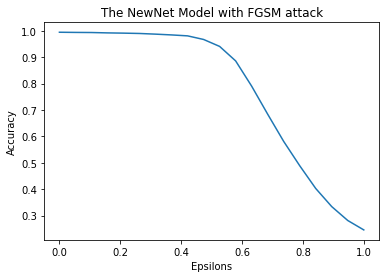

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
robust_accuracy = []
for i in range(20):
    acc = 1 - adv_info[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)
ax.plot(epsilon, robust_accuracy)
ax.set_xlabel("Epsilons")
ax.set_ylabel("Accuracy")
ax.set_title("The NewNet Model with FGSM attack")

### Metrics

In [37]:
def model_metrics(adv_imgs, real_imgs, epi_len):
    """
    Function to compute density & coverage for the between the 
    real & adversarial samples
    
    Parameters
    ---------------
    adv_imgs: ep.tensor, the generated adversarial samples, size: no_of_images x image_dims
    real_imgs: torch.tensor, size: no_of_images x dims
    epi_len: integer, the length or number of epsilons used for the attack
    """
    density = []
    coverage = []
    if not epi_len==1:
        for i in range(epi_len):
            # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
            gen = adv_imgs[i].raw.view(adv_imgs[i].shape[0], -1).cpu()

            # density
            density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

            # coverage
            coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
    else:
        gen = adv_imgs.raw.view(adv_imgs.shape[0], -1).cpu()

        # density
        density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

        # coverage
        coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
        
    return density, coverage

### - density & coverage for

#### --> model_dataset & adversarial samples 

In [18]:
# resize the real images
real = images.raw.view(images.shape[0], -1)

# 20 values of epsilons were considered
# find the density & coverage for each vgalue of epsilons
#density = []
#coverage = []
#for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    #gen = adv_images[i].raw.view(adv_images[i].shape[0], -1)
    
    # density
    #density.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    #coverage.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

#### --> model_dataset & validation set

In [19]:
# images from the validation set
gen_validate = torch.from_numpy(np.array(vali_images).reshape(len(vali_images), -1)).to(device)
gen_labels = torch.from_numpy(np.array(vali_labels)).to(device)
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

tensor(0.9972) tensor(0.3916)


#### Attack the model using validation dataset

In [23]:
vali_imagesx = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_labelsx = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))
print(vali_imagesx.shape, vali_labelsx.shape)

torch.Size([2100, 1, 28, 28]) torch.Size([2100])


In [24]:
adv_vali, adv_info_vali = model_attack(attack2, original_model, vali_imagesx, vali_labelsx, epsilon)

#### --> model_dataset and validation adversarial samples

In [26]:
vali_den = []
vali_cov = []
for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    gen = adv_vali[i].raw.view(adv_vali[i].shape[0], -1)
    
    # density
    vali_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    vali_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

In [28]:
robust_accuracy = []
for i in range(20):
    acc = 1 - adv_info_vali[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)

In [39]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
#print(f"Model_dataset & adversarial samples")
density_data = []
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Vali_adv_density: {:.5f}".format(epsilon[i], robust_accuracy[i], vali_den[i]))
    density_data.append([epsilon[i], robust_accuracy[i], vali_den[i].cpu().numpy()])

density_data = np.array(density_data)

Density
Model_dataset & validation set: density: 0.99724
Epsilon: 0.00000, Accuracy: 0.99%, Vali_adv_density: 0.99724
Epsilon: 0.05263, Accuracy: 0.99%, Vali_adv_density: 1.19229
Epsilon: 0.10526, Accuracy: 0.99%, Vali_adv_density: 1.30190
Epsilon: 0.15789, Accuracy: 0.99%, Vali_adv_density: 1.30905
Epsilon: 0.21053, Accuracy: 0.99%, Vali_adv_density: 1.22438
Epsilon: 0.26316, Accuracy: 0.98%, Vali_adv_density: 1.05514
Epsilon: 0.31579, Accuracy: 0.98%, Vali_adv_density: 0.81581
Epsilon: 0.36842, Accuracy: 0.98%, Vali_adv_density: 0.57400
Epsilon: 0.42105, Accuracy: 0.98%, Vali_adv_density: 0.35933
Epsilon: 0.47368, Accuracy: 0.96%, Vali_adv_density: 0.32448
Epsilon: 0.52632, Accuracy: 0.93%, Vali_adv_density: 0.29457
Epsilon: 0.57895, Accuracy: 0.88%, Vali_adv_density: 0.25695
Epsilon: 0.63158, Accuracy: 0.78%, Vali_adv_density: 0.22171
Epsilon: 0.68421, Accuracy: 0.68%, Vali_adv_density: 0.18600
Epsilon: 0.73684, Accuracy: 0.57%, Vali_adv_density: 0.15257
Epsilon: 0.78947, Accuracy: 

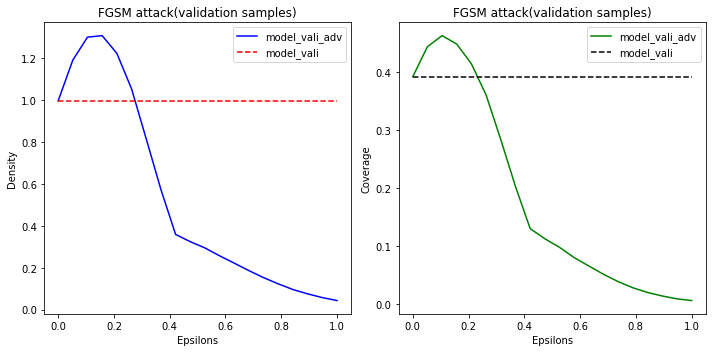

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(epsilon, vali_den, c='b', label='model_vali_adv')
ax[0].plot(epsilon, np.repeat(density_validate, len(epsilon)), ls='--', c='r', label='model_vali')
ax[0].set_xlabel("Epsilons")
ax[0].set_ylabel("Density")
ax[0].set_title("FGSM attack(validation samples)")
ax[0].legend()
ax[1].plot(epsilon, vali_cov, c='g', label='model_vali_adv')
ax[1].plot(epsilon, np.repeat(coverage_validate, len(epsilon)), ls='--', c='k', label='model_vali')
ax[1].set_xlabel("Epsilons")
ax[1].set_ylabel("Coverage")
ax[1].set_title("FGSM attack(validation samples)")
ax[1].legend()
fig.tight_layout()
plt.savefig("FGSM_attack_vali_samples.png")

In [40]:
print("Coverage")
print(f"Model_dataset & validation set: coverage: {coverage_validate}")
print(f"Model_dataset & adversarial samples")
coverage_data = []
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Vali_adv_coverage: {:.5f}".format(epsilon[i], robust_accuracy[i], vali_cov[i]))
    coverage_data.append([epsilon[i], robust_accuracy[i], vali_cov[i].cpu().numpy()])

coverage_data = np.array(coverage_data)

Coverage
Model_dataset & validation set: coverage: 0.39160001277923584
Model_dataset & adversarial samples
Epsilon: 0.00000, Accuracy: 0.99%, Vali_adv_coverage: 0.39160
Epsilon: 0.05263, Accuracy: 0.99%, Vali_adv_coverage: 0.44340
Epsilon: 0.10526, Accuracy: 0.99%, Vali_adv_coverage: 0.46240
Epsilon: 0.15789, Accuracy: 0.99%, Vali_adv_coverage: 0.44785
Epsilon: 0.21053, Accuracy: 0.99%, Vali_adv_coverage: 0.41365
Epsilon: 0.26316, Accuracy: 0.98%, Vali_adv_coverage: 0.36000
Epsilon: 0.31579, Accuracy: 0.98%, Vali_adv_coverage: 0.28325
Epsilon: 0.36842, Accuracy: 0.98%, Vali_adv_coverage: 0.20250
Epsilon: 0.42105, Accuracy: 0.98%, Vali_adv_coverage: 0.13010
Epsilon: 0.47368, Accuracy: 0.96%, Vali_adv_coverage: 0.11265
Epsilon: 0.52632, Accuracy: 0.93%, Vali_adv_coverage: 0.09785
Epsilon: 0.57895, Accuracy: 0.88%, Vali_adv_coverage: 0.08020
Epsilon: 0.63158, Accuracy: 0.78%, Vali_adv_coverage: 0.06570
Epsilon: 0.68421, Accuracy: 0.68%, Vali_adv_coverage: 0.05140
Epsilon: 0.73684, Accurac

- save/write the density_data & coverage_data
- info: attack model with model_dataset -> model_dataset & adversarial samples
- attack model validataion_dataset -> model_dataset & vali_adv samples
- model_dataset & vali_dataset

In [41]:
with open('FGSM_attack_density.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(20000 images)" + "\n" +
                 "# and validation_images(2100) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy Vali_adv_density" + "\n" +
                 "# Model_dataset & validation set: " + str(density_validate.cpu().numpy()) + "\n" )

with open('FGSM_attack_coverage.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(20000 images)" + "\n" +
                 "# and valiudation_images(2100) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy Model_adv_coverage Vali_adv_coverage" + "\n" +
                 "# Model_dataset & validation set: " + str(coverage_validate.cpu().numpy()) + "\n")
with open('FGSM_attack_density.dat', 'a') as addfile:
    np.savetxt(addfile, density_data)
    
with open('FGSM_attack_coverage.dat', 'a') as addfile:
    np.savetxt(addfile, coverage_data)

### Metrics for FGSM Attack - stats

- ```Batch_modelvali_metrics``` - density & coverage between model_dataset(20000) & validation_dataset(2100) in batches of 100 samples
- ```Batch_modelvali_adv_metrics``` - attack the model in batches using validation_dataset. Computed density & coverage between model_dataset & validation_adv samples

In [107]:
def model_validation_metrics_batches(real, images, labels):
    """
    Function to obtain density and coverage between model_dataset & 
    validation_dataset in batches (100 images)
    
    Parameters
    ---------------
    real: the model_dataset of (20000 images) using stratify split, torch.Tensor
    images: the validation_dataset fo (2100 images) , torch.Tensor
    labels: the labels for the validation_dataset, torch.Tensor
    
    Return
    -----------------
    bacth_model_vali_metrics: list containing density & coverage
    """
    batches = np.arange(0, 2100, 100)
    

    bacth_model_vali_metrics = []
    images = images.view(images.shape[0], -1)
    for i in range(len(batches)-1):

        # model_dataset & validation_dataset in batches
        start = batches[i]; end= batches[i+1]
        gen_validatex = images[start:end,...]
        gen_labelsx = labels[start:end]
        density_validatex = gem_build_density(real, real.shape[0], gen_validatex, 'indexflatl2')
        coverage_validatex = gem_build_coverage(real, real.shape[0], gen_validatex, 'indexflatl2')
        bacth_model_vali_metrics.append([density_validatex.cpu().numpy(), coverage_validatex.cpu().numpy()])
   
    return bacth_model_vali_metrics
        

In [15]:
def batch_validation_attack(real, images, labels, epi):
    """
    Function to obtain the density & coverage between model_dataset & validation_adv dataset
    
    - attack the model in batches of validation dataset(100 images)
    - for each epsilon value, compute the density & coverage for model_dataset & adv batch
    
    Parameters
    -------------
    real: real: the model_dataset of (20000 images) using stratify split, torch.Tensor
    images: images: the validation_dataset fo (2100 images) , torch.Tensor
    labels: the labels for the validation_dataset, torch.Tensor
    epi: np.array, epsilons for the attack
    
    Return
    -------------
    batch_model_vali_adv_metrics: list containing density & coverage
    """
    advs = []
    batch_model_vali_adv_metrics = []
    batches = np.arange(0, 2100, 100)
    images = ep.astensor(images)
    labels = ep.astensor(labels)
    for i in range(len(batches)-1):
        start = batches[i]; end= batches[i+1]
        imagesx = images[start:end,...]
        labelsx = labels[start:end]
        adv_fgsm_batch, adv_fgsm_batch_info = model_attack(attack2, original_model, imagesx, labelsx, epi)
        #advs.append(adv_fgsm_batch)
    #print(adv_fgsm_batch[0].shape)
    #print(len(advs[0]))
        for i in range(len(adv_fgsm_batch)):
            gen = adv_fgsm_batch[i].raw.view(len(adv_fgsm_batch[i]), -1)
            densityx = gem_build_density(real, real.shape[0], gen, 'indexflatl2')
            coveragex = gem_build_coverage(real, real.shape[0], gen, 'indexflatl2')
            batch_model_vali_adv_metrics.append([densityx.cpu().numpy(), coveragex.cpu().numpy()])
    
    return batch_model_vali_adv_metrics

In [108]:
realx = torch.from_numpy(np.array(X_images)).view(len(X_images), -1).to(device)
vali_attk_images = torch.from_numpy(np.array(vali_images)).to(device)
vali_attk_labels = torch.from_numpy(np.array(vali_labels)).to(device)
epsilon = np.linspace(0.0, 1, num=20)


In [114]:
Batch_modelvali_metrics = model_validation_metrics_batches(realx, vali_attk_images, vali_attk_labels)

In [115]:
with open('FGSM_attack_batch_metrics.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(20000 images)" + "\n" +
                 "# and valiudation_images(2100) 20 epsilon in batches of 100 images" + "\n" +
                 "# metrics between model_dataset & validation dataset" + "\n" +
                 "# Model_vali_density Model_vali_coverage" + "\n" )
with open('FGSM_attack_batch_metrics.dat', 'a') as newfile:
    np.savetxt(newfile, np.array(Batch_modelvali_metrics))

In [26]:
Batch_modelvali_adv_metrics = batch_validation_attack(realx, vali_attk_images, vali_attk_labels, epsilon)

## Plotting ```FGSM attack```

- ```df_nmodel_vali_density```- model_dataset & validation_dataset
- ```df_nmodel_vali_adv_density```- for each epsilon -> model_dataset & validation adv samples
- **n** in name denotes not the batch samples

In [53]:
df_nmodel_vali_density = pd.read_csv("metrics_files/FGSM_attack_density.dat", header=None, nrows=4)
df_nmodel_vali_adv_density = pd.read_csv("metrics_files/FGSM_attack_density.dat", header=None, skiprows=4, sep=" ")

In [54]:
df_bmodel_vali_metrics = pd.read_csv("metrics_files/FGSM_attack_batch_metrics.dat", header=None, skiprows=4, sep=" ")
df_bmodel_vali_adv_metrics =pd.read_csv("metrics_files/FGSM_attack_batch_adv_metrics.dat", header=None, skiprows=5, sep=" ")

In [58]:
nmodel_vali_density = float((list(df_nmodel_vali_density.iloc[3].values))[0].split()[-1])
nmodel_vali_adv_density = df_nmodel_vali_adv_density.iloc[:, -1].values

In [59]:
bmodel_vali_density = df_bmodel_vali_metrics.iloc[:, 0].values
bmodel_vali_adv_metrics = df_bmodel_vali_adv_metrics.iloc[:, 1].values

val_mean = []
val_std = []
for i in range(0, len(bmodel_vali_adv_metrics), 20):
    val_mean.append(np.mean(bmodel_vali_adv_metrics[i:((i+1)*10)]))
    val_std.append(np.std(bmodel_vali_adv_metrics[i:((i+1)*10)]))
    
val_mean = np.array(val_mean); val_std = np.array(val_std)
val_mean.shape, val_std.shape

((20,), (20,))

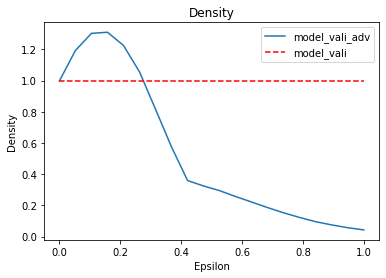

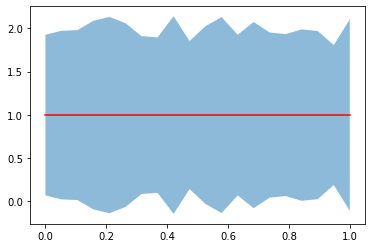

In [60]:
plt.figure(1)
plt.plot(epsilon, nmodel_vali_adv_density, label='model_vali_adv')
plt.plot(epsilon, np.repeat(nmodel_vali_density, len(epsilon)), ls='--',c='r', label='model_vali')
plt.xlabel("Epsilon")
plt.ylabel("Density")
plt.title("Density")
plt.legend()
#plt.fill_between(epsilon, nmodel_vali_adv_density+val_mean, nmodel_vali_adv_density-val_mean, alpha=0.2)

plt.figure(2)
plt.plot(epsilon, np.repeat(nmodel_vali_density, len(epsilon)), c='r')
plt.fill_between(epsilon, np.repeat(nmodel_vali_density, len(epsilon))+bmodel_vali_density, np.repeat(nmodel_vali_density, len(epsilon))-bmodel_vali_density, alpha=0.5)

In [48]:
df_nmodel_vali_cov = pd.read_csv("metrics_files/FGSM_attack_coverage.dat", header=None, nrows=4)
df_nmodel_vali_adv_cov = pd.read_csv("metrics_files/FGSM_attack_coverage.dat", header=None, skiprows=4, sep=" ")

In [52]:
nmodel_vali_cov = float((list(df_nmodel_vali_cov.iloc[3].values))[0].split()[-1])
nmodel_vali_adv_cov = df_nmodel_vali_adv_cov.iloc[:, -1].values

In [55]:
bmodel_vali_cov = df_bmodel_vali_metrics.iloc[:, 1]
new = np.array([nmodel_vali_cov - bmodel_vali_cov, nmodel_vali_cov+bmodel_vali_cov])

In [56]:
new.shape

(2, 20)

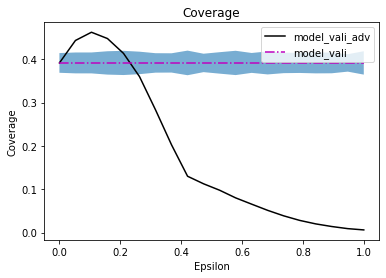

In [57]:
plt.figure(1)
plt.plot(epsilon, nmodel_vali_adv_cov, c='k', label='model_vali_adv')
plt.plot(epsilon, np.repeat(nmodel_vali_cov, len(epsilon)), ls="-.", c='m', label='model_vali')
plt.fill_between(epsilon, new[0,...], new[1,...], alpha=0.6)
plt.xlabel("Epsilon")
plt.ylabel("Coverage")
plt.title("Coverage")
plt.legend()

## Attack the model using ```Boundary attack```

This attack works fine i.e, adversarial samples are created if epsilon is assigned as None

In [88]:
# manage memory
#del md_images; del md_labels; del images; del labels
#torch.cuda.empty_cache()
#print(torch.cuda.memory_allocated())

In [129]:
BdyAttack = fb.attacks.BoundaryAttack()

#### Test attack using images & labels from foolbox

This step is done to make sure adversarial samples are generated with the current version of foolbox

In [66]:
test_imgs, test_labels = ep.astensors(*samples(original_model, dataset='mnist', batchsize=16))
raw_advs, clipped_advs, success = BdyAttack(original_model, test_imgs, test_labels, epsilons=None)

In [67]:
robust_accuracy = 1 - success.float32().mean(axis=-1)
print("robust accuracy: ", robust_accuracy)

robust accuracy:  PyTorchTensor(tensor(0., device='cuda:0'))


#### Test attack using validation images

A subset of 10 images from the validation_set is used for the attack

In [9]:
vali_attk_images = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_attk_labels = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))

In [69]:
attak = fb.attacks.BoundaryAttack()
_, _, newsuccess = BdyAttack(original_model, vali_attk_images[:10,...], vali_attk_labels[:10], epsilons=None)

In [70]:
robust_acc = 1 - newsuccess.float32().mean(axis=-1)
print("robust accuracy: ", robust_accuracy)

robust accuracy:  PyTorchTensor(tensor(0., device='cuda:0'))


### Attack the model using entire validation_dataset

- the Boundary Attack cannot be implemented if the starting images are not adversaries
- to create these adversarial samples, ```init_attack``` needs to be specified
- any of the attacks inherited from ```Minimization Attack``` can be used for this purpose
- all the initial samples should be strictly adversarial samples

##### Two different attacks were experimented
- ```SaltandPepper```, ```LinearSearchBlendedUniformNoiseAttack```
- modify the hyperparameters within these attacks to generate the adversarial samples
- the generated samples are given as the starting points for the ```BoundaryAttack```
- time complexity increases with changing these hyperparameters

In [127]:
s_attack = fb.attacks.SaltAndPepperNoiseAttack()
n_attack = fb.attacks.LinearSearchBlendedUniformNoiseAttack(directions=2000, steps=5000)
_, adv_lsbu, _ = n_attack(original_model, vali_attk_images, vali_attk_labels, epsilons=None)

In [131]:
_, adv_bdy, adv_bdy_info = BdyAttack(original_model, vali_attk_images, vali_attk_labels, starting_points=adv_lsbu, epsilons=None)

In [32]:
print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")

### Metrics

#### - entire model_dataset (67000) & validation_dataset (2100)

In [134]:
real = md_images.view(md_images.shape[0], -1).to(device)
# images from the validation set
gen_validate = vali_attk_images.view(vali_attk_images.shape[0], -1)
gen_labels = vali_attk_labels
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

tensor(1.0072, device='cuda:0') tensor(0.1424, device='cuda:0')


#### - model_dataset & validation_dataset adversarials

In [136]:
gen_adv_val = adv_bdy.view(adv_bdy.shape[0], -1)
model_density_val = gem_build_density(real, real.shape[0], gen_adv_val, 'indexflatl2')
model_coverage_val = gem_build_coverage(real, real.shape[0], gen_adv_val, 'indexflatl2')
print(model_density_val, model_coverage_val)

tensor(0.1596, device='cuda:0') tensor(0.0047, device='cuda:0')


In [21]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
print(f"Model_dataset & validation adv (2100): density: {model_density_val:.5f}")

Density
Model_dataset & validation set: density: 1.00724
Model_dataset & validation adv(2100): density: 0.15571


### Attack the model with validation_dataset in batches

- create the adversarial samples for each batch exclusively
- use these images as starting_points for boundary attack

#### Get the adversarial starting points for each Batch
- load the 100Batch_Vali_Adv_LSBU.pt file for the saved LSBU adversarials

In [37]:
batches = np.arange(0, 2100, 100)
success = []
batch_adv_samples = []
for i in range(len(batches)-1):
    start = batches[i]; end= batches[i+1]
    _, batch_adv_lsbu, _ = n_attack(original_model, vali_attk_images[start:end,...], vali_attk_labels[start:end], epsilons=None)
    print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")
    success.append(adv_bdy_info); batch_adv_samples.append(batch_adv_lsbu.raw)

In [36]:
batch_adv_lsbu_samples = torch.stack(batch_adv_samples)
torch.save(batch_adv_lsbu_samples, '100Batch_Vali_Adv_LSBU.pt')

In [39]:
batch_lsbu_adv = torch.load('100Batch_Vali_Adv_LSBU.pt', map_location='cpu').to(device)

### BoundaryAttack on the model using batches of validation_dataset

In [41]:
batch_bdy_adv = []
batch_bdy_info = []
for i in range(len(batches)-1):
    start = batches[i]; end= batches[i+1]
    _, adv_bdy, adv_bdy_info = BdyAttack(original_model, vali_attk_images[start:end,...], vali_attk_labels[start:end], 
                                         starting_points=batch_lsbu_adv[i], epsilons=None)
    batch_bdy_adv.append(adv_bdy); batch_bdy_info.append(adv_bdy_info)

### Metrics

- #### model_dataset & validation_dataset in batches
- #### model_deataset & validation adv in batches

In [45]:
batch_density_validate = []
batch_coverage_validate = []
batch_model_density = []
batch_model_coverage = []

for i in range(len(batches)-1):
    # model_dataset & validation_dataset in batches
    start = batches[i]; end= batches[i+1]
    bth_val_imgs = vali_attk_images[start:end,...]
    gen_validatex = bth_val_imgs.raw.view(bth_val_imgs.shape[0], -1)
    gen_labelsx = vali_attk_labels[start:end].raw
    density_validatex = gem_build_density(real, real.shape[0], gen_validatex, 'indexflatl2')
    coverage_validatex = gem_build_coverage(real, real.shape[0], gen_validatex, 'indexflatl2')
    
    # model_dataset & validation_dataset adversarials in batches
    gen_adv_valx = batch_bdy_adv[i].raw.view(batch_bdy_adv[i].shape[0], -1)
    model_density_valx = gem_build_density(real, real.shape[0], gen_adv_valx, 'indexflatl2')
    model_coverage_valx = gem_build_coverage(real, real.shape[0], gen_adv_valx, 'indexflatl2')
    
    batch_density_validate.append(density_validatex)
    batch_coverage_validate.append(coverage_validatex)
    batch_model_density.append(model_density_valx)
    batch_model_coverage.append(model_coverage_valx)


In [64]:
with open('Boundary_attack_metrics.dat', 'w') as newfile:
    newfile.write("# Boundary attack with validation_dataset(2100 images)" + "\n" +
                 "# and metrics using model_dataset(67000)" + "\n" +
                 "# Model_dataset & validation set: density: " + str(density_validate.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation adv (2100): density: " + str(model_density_val.cpu().numpy()) + "\n" +
                 "# batch_no model_val_density model_val_adv_density model_val_coverage model_val_adv_coverage" + "\n")
    
with open('Boundary_attack_metrics.dat', 'a') as nefile:
    for i in range (len(batch_density_validate)):
        nefile.write(str(i)+ " " + str(batch_density_validate[i].cpu().numpy())+ " " + str(batch_model_density[i].cpu().numpy())+ " " +
                    str(batch_coverage_validate[i].cpu().numpy()) + " " + str(batch_model_coverage[i].cpu().numpy()) + "\n")

## Plotting

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
df_bdy_attack_basic = pd.read_csv('metrics_files/Boundary_attack_metrics.dat', header=None, nrows=5)
df_bdy_attack_all = pd.read_csv('metrics_files/Boundary_attack_metrics.dat', header=None, sep=" ", skiprows=5)

In [141]:
df_bdy_coverage_basic = pd.read_csv('metrics_files/Boundary_attack_coverage.dat', header=None, nrows=4)

In [142]:
model_validation_den = float((list(df_bdy_attack.iloc[2].values))[0].split()[-1])
model_validation_adv_den = float((list(df_bdy_attack.iloc[3].values))[0].split()[-1])
model_validation_cov = float((list(df_bdy_coverage_basic.iloc[2].values))[0].split()[-1])
model_validation_adv_cov = float((list(df_bdy_coverage_basic.iloc[3].values))[0].split()[-1])

(0.14238586, 0.0047275405)

In [119]:
model_validation_adv_den, model_validation_den

(0.15571429, 1.0072381)

In [147]:
# density
derror = df_bdy_attack_all.iloc[:,1].values
dx = np.repeat(model_validation_den, len(derror))

derror_adv = df_bdy_attack_all.iloc[:,2].values
dadv_x = np.repeat(model_validation_adv_den, len(derror_adv))

# coverage
cerror = df_bdy_attack_all.iloc[:,3].values
cx = np.repeat(model_validation_cov, len(cerror))

cerror_adv = df_bdy_attack_all.iloc[:,4].values
cadv_x = np.repeat(model_validation_adv_cov, len(cerror_adv))

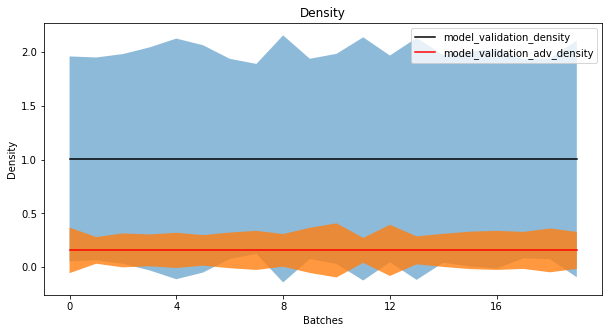

In [199]:
# plot density
plt.figure(figsize=(10,5))
plt.plot(range(len(derror)), dx, c='k', label='model_validation_density')
plt.fill_between(range(len(derror)), dx-derror, dx+derror, alpha=0.5)

plt.plot(range(len(derror_adv)), dadv_x, c='r', label='model_validation_adv_density')
plt.fill_between(range(len(derror_adv)), dadv_x-derror_adv, dadv_x+derror_adv, alpha=0.8)

plt.xticks(range(0,20,4))
plt.xlabel('Batches')
plt.ylabel('Density')
plt.title('Density')
plt.legend()
plt.savefig("BoundaryAttack_density.png")

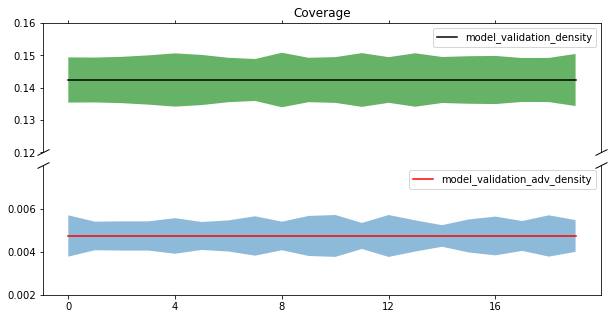

In [200]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax1.plot(range(len(cerror)), cx, c='k', label='model_validation_density')
ax1.fill_between(range(len(cerror)), cx-cerror, cx+cerror, alpha=0.6, facecolor='g')
ax1.legend()
ax2.plot(range(len(cerror_adv)), cadv_x, c='r', label='model_validation_adv_density')
ax2.fill_between(range(len(cerror_adv)), cadv_x-cerror_adv, cadv_x+cerror_adv, alpha=0.5)
ax2.legend()
ax1.set_ylabel("Coverage")
ax1.set_title("Coverage")

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(.12, 0.16)  # outliers only
ax2.set_ylim(0.002, .008)  # most of the data
ax2.set_yticks(np.arange(0.002, 0.008, 0.002))

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False) # don't put tick labels at the top
ax2.set_xticks(range(0,21,4))
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig("BoundaryAttack_coverage.png")

## The End